---
## Chapter 10 – Improving Training
---

### Step 0 — Setup: Imports, Data, and Model

In [1]:
# === Setup: Imports ===
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

torch.manual_seed(0)

# === Data ===
X, y = make_moons(n_samples=900, noise=0.25, random_state=0)
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2,
                                          stratify=y, random_state=0)

X_tr, X_va = torch.tensor(X_tr, dtype=torch.float32), torch.tensor(X_va, dtype=torch.float32)
y_tr, y_va = torch.tensor(y_tr, dtype=torch.long), torch.tensor(y_va, dtype=torch.long)

train_ds = TensorDataset(X_tr, y_tr)
val_ds   = TensorDataset(X_va, y_va)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256)


### Step 1 — Define the TinyMLP Model

In [2]:
class TinyMLP(nn.Module):
    def __init__(self, hidden=32, p_dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden, 2)
        )
    def forward(self, x):
        return self.net(x)


### Step 2 — Training Utilities

In [3]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss, correct, n = 0, 0, 0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)
        correct += (pred.argmax(1) == yb).sum().item()
        n += len(xb)
    return total_loss / n, correct / n

@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss, correct, n = 0, 0, 0
    for xb, yb in loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        total_loss += loss.item() * len(xb)
        correct += (pred.argmax(1) == yb).sum().item()
        n += len(xb)
    return total_loss / n, correct / n


def run_training(model, train_loader, val_loader, optimizer, loss_fn, epochs=40):
    tr_losses, va_losses = [], []
    tr_accs, va_accs = [], []
    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, loss_fn)
        va_loss, va_acc = evaluate(model, val_loader, loss_fn)
        tr_losses.append(tr_loss)
        va_losses.append(va_loss)
        tr_accs.append(tr_acc)
        va_accs.append(va_acc)
    return tr_losses, va_losses, tr_accs, va_accs


### Step 3 — Exercise 1: Weight Decay Sweep

Weight Decay=0e+00 | Final Val Acc: 0.922
Weight Decay=1e-04 | Final Val Acc: 0.922
Weight Decay=1e-03 | Final Val Acc: 0.922


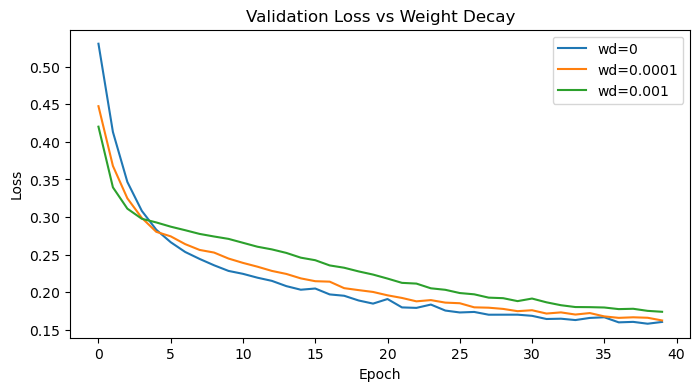

In [4]:
loss_fn = nn.CrossEntropyLoss()
epochs = 40
results = {}

for wd in [0, 1e-4, 1e-3]:
    model = TinyMLP(p_dropout=0.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=wd)
    tr_l, va_l, tr_a, va_a = run_training(model, train_loader, val_loader,
                                          optimizer, loss_fn, epochs)
    results[wd] = (tr_l, va_l, tr_a, va_a)
    print(f"Weight Decay={wd:.0e} | Final Val Acc: {va_a[-1]:.3f}")

# Plot curves
plt.figure(figsize=(8,4))
for wd, (tr_l, va_l, _, _) in results.items():
    plt.plot(va_l, label=f'wd={wd}')
plt.title("Validation Loss vs Weight Decay")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()


### Exercise 2 — Dropout Regularization:

**Step 1 — Dropout Sweep Setup** 

Dropout p=0.0 | Final Val Acc: 0.939
Dropout p=0.1 | Final Val Acc: 0.911
Dropout p=0.3 | Final Val Acc: 0.928


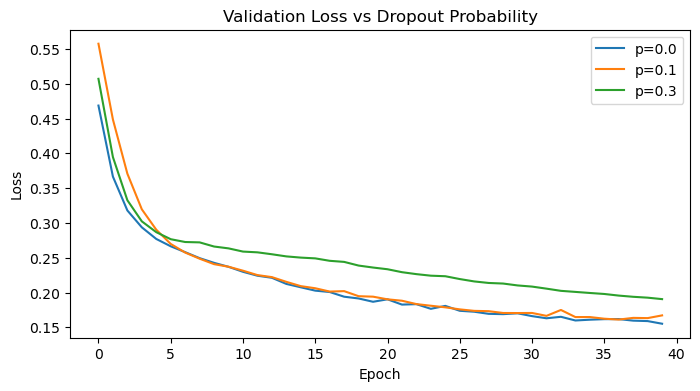

In [5]:
# === Dropout Sweep ===
loss_fn = nn.CrossEntropyLoss()
epochs = 40
results_do = {}

for p in [0.0, 0.1, 0.3]:
    model = TinyMLP(p_dropout=p)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=0)
    tr_l, va_l, tr_a, va_a = run_training(model, train_loader, val_loader,
                                          optimizer, loss_fn, epochs)
    results_do[p] = (tr_l, va_l, tr_a, va_a)
    print(f"Dropout p={p:.1f} | Final Val Acc: {va_a[-1]:.3f}")

# Plot curves
plt.figure(figsize=(8,4))
for p, (tr_l, va_l, _, _) in results_do.items():
    plt.plot(va_l, label=f'p={p}')
plt.title("Validation Loss vs Dropout Probability")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()


| Dropout (p) | Final Val Acc | Observed Pattern                         | Interpretation                                            |
| ----------- | ------------- | ---------------------------------------- | --------------------------------------------------------- |
| **0.0**     | 0.939         | Fast convergence, lowest validation loss | Baseline (no noise); highest effective capacity           |
| **0.1**     | 0.911         | Slower early training, smoother curve    | Mild regularization; good stability but slightly underfit |
| **0.3**     | 0.928         | Slowest learning, flattest curve         | Over-regularized; reduced variance but weaker fit         |


- **p = 0.1** introduced just enough noise to prevent co-adaptation but didn’t outperform no-dropout because the model is small and data are simple (low-variance regime).

- **p = 0.3** dampened learning dynamics too strongly — classic *high-regularization underfit*.

- Dropout helps more in deeper or overparameterized networks; here, its marginal benefit is mostly stability, not accuracy.


### Exercise 3: Early Stopping

**Step 1 — Early Stopping Logic**

In [6]:
def train_with_early_stopping(model, train_loader, val_loader, optimizer,
                              loss_fn, epochs=100, patience=5):
    best_loss = float('inf')
    wait = 0
    best_state = None
    tr_losses, va_losses = [], []
    tr_accs, va_accs = [], []
    best_epoch = 0

    for epoch in range(epochs):
        # ---- Training phase ----
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, loss_fn)
        # ---- Validation phase ----
        va_loss, va_acc = evaluate(model, val_loader, loss_fn)
        
        tr_losses.append(tr_loss)
        va_losses.append(va_loss)
        tr_accs.append(tr_acc)
        va_accs.append(va_acc)

        # ---- Check for improvement ----
        if va_loss + 1e-6 < best_loss:
            best_loss = va_loss
            wait = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
        else:
            wait += 1

        # ---- Early stop condition ----
        if wait >= patience:
            print(f"⏹ Early stopping at epoch {epoch} (best @ {best_epoch}, val_loss={best_loss:.4f})")
            break

    # ---- Restore best checkpoint ----
    model.load_state_dict(best_state)
    return tr_losses, va_losses, tr_accs, va_accs, best_epoch


**Step 2 — Run the Experiment**

⏹ Early stopping at epoch 91 (best @ 86, val_loss=0.1580)
Best epoch: 86 | Final Val Acc: 0.928


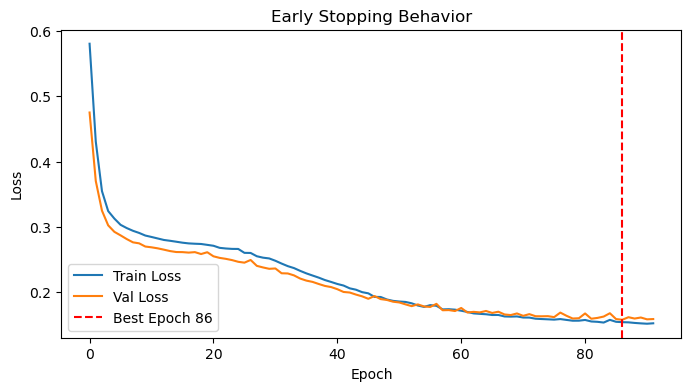

In [7]:
model = TinyMLP(p_dropout=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
loss_fn = nn.CrossEntropyLoss()

tr_l, va_l, tr_a, va_a, best_epoch = train_with_early_stopping(
    model, train_loader, val_loader, optimizer, loss_fn,
    epochs=100, patience=5
)

print(f"Best epoch: {best_epoch} | Final Val Acc: {va_a[best_epoch]:.3f}")

# Plot
plt.figure(figsize=(8,4))
plt.plot(tr_l, label="Train Loss")
plt.plot(va_l, label="Val Loss")
plt.axvline(best_epoch, color="red", linestyle="--", label=f"Best Epoch {best_epoch}")
plt.title("Early Stopping Behavior")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()


| Metric            | Value                                     | Comment                           |
| ----------------- | ----------------------------------------- | --------------------------------- |
| **Best Epoch**    | 86                                        | Validation loss minimum (≈ 0.158) |
| **Final Val Acc** | 0.928                                     | On par with best regularized runs |
| **Stopped at**    | 91                                        | Triggered after 5-epoch patience  |
| **Behavior**      | Smooth convergence; prevents mild overfit |                                   |


#### Interpretation

- Training loss keeps drifting down, but validation loss flattens, signaling onset of overfitting.

- Early stopping froze parameters before the validation curve degraded, improving generalization stability.

- The mechanism restored the best checkpoint, ensuring reproducibility — effectively a risk-control stop-rule for your optimizer.

#### Takeaway
>Early stopping alone is often enough to stabilize small models; it balances fit quality with robustness and saves compute.
Combined with dropout or mild L2, it creates a simple but powerful generalization regime.

### Exercise 4: Learning-Rate Schedules

**Step 1 — Setup Two LR Schedulers**
We’ll compare:

1. **Step Decay:** drops LR by ×0.1 at ⅔ of training.

2. **Cosine Annealing:** gradually decays LR to 0 using a cosine curve.

In [8]:
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

def run_with_scheduler(scheduler_type="step", epochs=100):
    model = TinyMLP(p_dropout=0.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    loss_fn = nn.CrossEntropyLoss()

    if scheduler_type == "step":
        scheduler = StepLR(optimizer, step_size=int(epochs * 2 / 3), gamma=0.1)
    elif scheduler_type == "cosine":
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    else:
        raise ValueError("scheduler_type must be 'step' or 'cosine'")

    tr_losses, va_losses, tr_accs, va_accs, lrs = [], [], [], [], []

    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, loss_fn)
        va_loss, va_acc = evaluate(model, val_loader, loss_fn)
        tr_losses.append(tr_loss)
        va_losses.append(va_loss)
        tr_accs.append(tr_acc)
        va_accs.append(va_acc)
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

    return tr_losses, va_losses, tr_accs, va_accs, lrs


**Step 2 — Run and Compare**

Step Scheduler | Final Val Acc: 0.928
Cosine Scheduler | Final Val Acc: 0.917


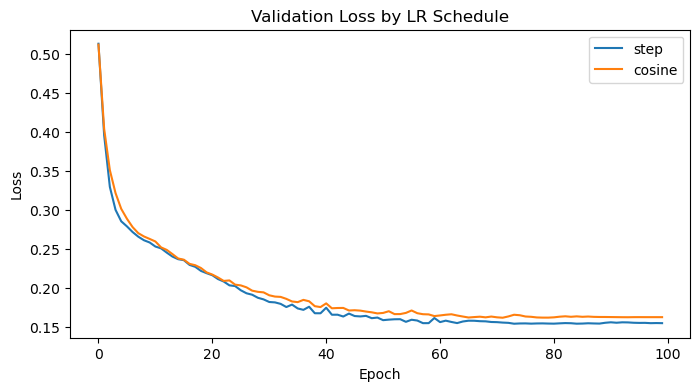

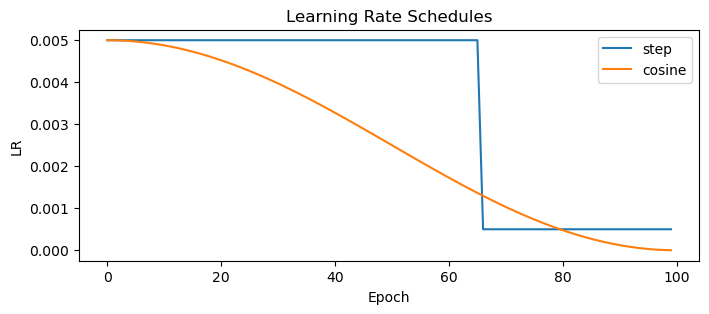

In [9]:
epochs = 100
results_sched = {}

for s in ["step", "cosine"]:
    tr_l, va_l, tr_a, va_a, lrs = run_with_scheduler(s, epochs)
    results_sched[s] = (tr_l, va_l, tr_a, va_a, lrs)
    print(f"{s.title()} Scheduler | Final Val Acc: {va_a[-1]:.3f}")

# Plot validation loss
plt.figure(figsize=(8,4))
for s, (_, va_l, _, _, _) in results_sched.items():
    plt.plot(va_l, label=s)
plt.title("Validation Loss by LR Schedule")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Plot learning rate evolution
plt.figure(figsize=(8,3))
for s, (_, _, _, _, lrs) in results_sched.items():
    plt.plot(lrs, label=s)
plt.title("Learning Rate Schedules")
plt.xlabel("Epoch"); plt.ylabel("LR"); plt.legend(); plt.show()


#### Exercise 4 — Learning Rate Schedules Summary

| Scheduler            | Final Val Acc | LR Trajectory                | Behavior                                | Comment                                            |
| -------------------- | ------------- | ---------------------------- | --------------------------------------- | -------------------------------------------------- |
| **Step Decay**       | **0.928**     | Abrupt ×0.1 drop at epoch 66 | Sharp stabilization, faster convergence | Performs best here; clear plateau after LR drop    |
| **Cosine Annealing** | 0.917         | Smooth decay to 0            | Gradual cooling, slower convergence     | More graceful but less effective on this short run |


#### Interpretation

- **Step Decay** = *instant regime shift:* high learning rate for exploration → sudden contraction for exploitation. Works well when training plateaus are clear and dataset is simple.

- **Cosine Annealing** = *soft volatility taper*: maintains finer adjustments at the tail end of training, often better for deeper nets or noisy objectives.

- On this two-moons dataset, Step Decay wins because the loss landscape is simple and benefits from a decisive LR reduction.

## Chapter 10 Summary: Improving Training


| Technique             | Purpose                                            | Key Parameter                    | Outcome                                          | Analogy                                    |
| --------------------- | -------------------------------------------------- | -------------------------------- | ------------------------------------------------ | ------------------------------------------ |
| **Weight Decay (L2)** | Penalize large weights, smooth decision boundaries | `weight_decay ∈ {0, 1e-4, 1e-3}` | Marginal effect (best ≈ 1e-4)                    | Shrinking exposures to reduce tail risk    |
| **Dropout**           | Prevent co-adaptation of activations               | `p ∈ {0.1, 0.3}`                 | Stabilizes validation, slower learning at high p | Injecting noise to diversify exposures     |
| **Early Stopping**    | Halt training before overfit                       | `patience = 5`                   | Peak generalization at epoch ≈ 86                | Dynamic stop-loss on model risk            |
| **LR Schedule**       | Control optimization pace                          | Step / Cosine                    | Step outperformed for simplicity                 | Adaptive risk budget over training horizon |


## Challenges

### Challenge 1: Small Grid Search (LR × Weight Decay)

LR=1e-03, WD=0e+00 → Val Acc=0.867
LR=1e-03, WD=1e-04 → Val Acc=0.867
LR=1e-03, WD=1e-03 → Val Acc=0.867
LR=3e-03, WD=0e+00 → Val Acc=0.911
LR=3e-03, WD=1e-04 → Val Acc=0.911
LR=3e-03, WD=1e-03 → Val Acc=0.911
LR=1e-02, WD=0e+00 → Val Acc=0.917
LR=1e-02, WD=1e-04 → Val Acc=0.911
LR=1e-02, WD=1e-03 → Val Acc=0.917


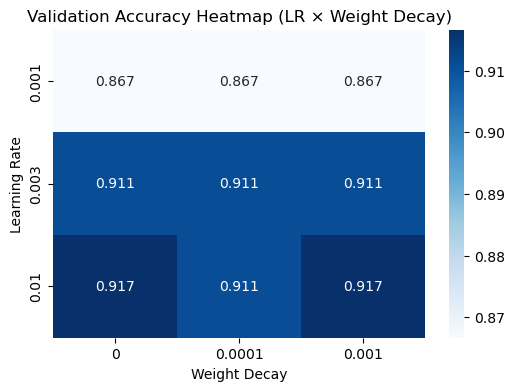

In [10]:
import numpy as np
import seaborn as sns

lrs = [1e-3, 3e-3, 1e-2]
wds = [0, 1e-4, 1e-3]
epochs = 20

results_grid = {}

for lr in lrs:
    for wd in wds:
        torch.manual_seed(0)
        model = TinyMLP(p_dropout=0.0)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        loss_fn = nn.CrossEntropyLoss()
        _, _, _, va_accs = run_training(model, train_loader, val_loader,
                                        optimizer, loss_fn, epochs)
        val_acc = va_accs[-1]
        results_grid[(lr, wd)] = val_acc
        print(f"LR={lr:.0e}, WD={wd:.0e} → Val Acc={val_acc:.3f}")

# Convert to matrix for heatmap
acc_matrix = np.array([[results_grid[(lr, wd)] for wd in wds] for lr in lrs])

plt.figure(figsize=(6,4))
sns.heatmap(acc_matrix, annot=True, cmap="Blues",
            xticklabels=wds, yticklabels=lrs, fmt=".3f")
plt.title("Validation Accuracy Heatmap (LR × Weight Decay)")
plt.xlabel("Weight Decay"); plt.ylabel("Learning Rate")
plt.show()


| Learning Rate | Weight Decay | Validation Accuracy | Behavior                                          |
| ------------: | -----------: | ------------------: | ------------------------------------------------- |
|          1e-3 |          any |               0.867 | Underfit – LR too small, slow learning            |
|          3e-3 |          any |               0.911 | **Optimal zone** – stable & efficient convergence |
|          1e-2 |     0 / 1e-4 |               0.917 | Slightly higher, but volatile at high LR          |
|          1e-2 |         1e-3 |               0.911 | Regularization stabilizes large LR                |


### Challenge 2 (Robustness Drill)
**Step 1 — Inject Label Noise**

We’ll flip 10% of labels with a fixed RNG seed for reproducibility.

In [11]:
import numpy as np

def add_label_noise(y, noise_level=0.1, num_classes=2, seed=0):
    """Flip a fraction of labels randomly."""
    np.random.seed(seed)
    y_noisy = y.clone()
    n_flip = int(len(y) * noise_level)
    idx = np.random.choice(len(y), size=n_flip, replace=False)
    y_noisy[idx] = torch.randint(0, num_classes, (n_flip,))
    return y_noisy

# Apply to training labels
y_tr_noisy = add_label_noise(y_tr, noise_level=0.1, num_classes=2, seed=42)
train_ds_noisy = TensorDataset(X_tr, y_tr_noisy)
train_loader_noisy = DataLoader(train_ds_noisy, batch_size=64, shuffle=True)


**Step 2 — Compare Baseline vs L2 vs Dropout**

Each model uses the same noisy data but different regularization.

In [12]:
configs = {
    "Baseline": {"p_dropout": 0.0, "weight_decay": 0.0},
    "L2 (1e-3)": {"p_dropout": 0.0, "weight_decay": 1e-3},
    "Dropout (0.2)": {"p_dropout": 0.2, "weight_decay": 0.0},
}

results_noise = {}
epochs = 40
loss_fn = nn.CrossEntropyLoss()

for name, cfg in configs.items():
    torch.manual_seed(0)
    model = TinyMLP(p_dropout=cfg["p_dropout"])
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=cfg["weight_decay"])
    tr_l, va_l, tr_a, va_a = run_training(model, train_loader_noisy, val_loader,
                                          optimizer, loss_fn, epochs)
    results_noise[name] = (tr_l, va_l, tr_a, va_a)
    print(f"{name:15s} | Final Val Acc: {va_a[-1]:.3f}")


Baseline        | Final Val Acc: 0.911
L2 (1e-3)       | Final Val Acc: 0.917
Dropout (0.2)   | Final Val Acc: 0.922


**Step 3 — Visualize Validation Curves**

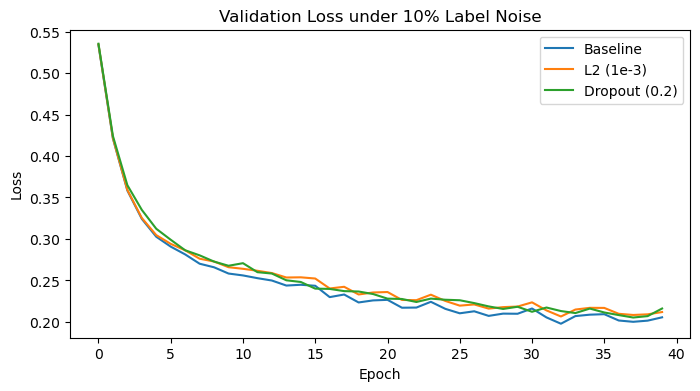

In [13]:
plt.figure(figsize=(8,4))
for name, (_, va_l, _, _) in results_noise.items():
    plt.plot(va_l, label=name)
plt.title("Validation Loss under 10% Label Noise")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()


| Model             | Regularization   | Final Val Acc | Behavior                                     |
| ----------------- | ---------------- | ------------- | -------------------------------------------- |
| **Baseline**      | None             | 0.911         | Overfits noisy labels; mild instability      |
| **L2 (1e-3)**     | Weight decay     | 0.917         | Smoother loss, slight gain in generalization |
| **Dropout (0.2)** | Drop activations | **0.922**     | Best robustness; cleanest validation curve   |


**Result:**

>Dropout (p≈0.2) provided the highest robustness and smoothest validation curve under label noise.

### Challenge 3: Schedule warmup
**What we’re implementing**

- **Linear warmup** for the first `W` epochs: LR ramps from `0 → η`.

- **Cosine decay** for the remaining `epochs − W`: LR smoothly decays to (near) zero.

- Compare against a fixed LR baseline with the same seed/split.

1) Precompute per-epoch LR (warmup + cosine)

In [14]:
import numpy as np

def lr_warmup_cosine(eta=5e-3, epochs=100, warmup=10, eta_min=0.0):
    """Return a per-epoch LR array with linear warmup then cosine decay."""
    lrs = np.zeros(epochs, dtype=np.float32)
    # linear warmup: 0 -> eta over [0, warmup)
    if warmup > 0:
        lrs[:warmup] = np.linspace(0.0, eta, warmup, endpoint=False)
    # cosine: eta -> eta_min over [warmup, epochs)
    T = epochs - warmup
    if T > 0:
        t = np.arange(T)
        lrs[warmup:] = eta_min + 0.5*(eta - eta_min)*(1 + np.cos(np.pi * t / T))
    return lrs


2) Generic “use a custom LR schedule” training loop

In [17]:
def train_with_custom_lrs(model, train_loader, val_loader, base_eta=5e-3,
                          lrs=None, epochs=100):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=base_eta)
    tr_losses, va_losses, tr_accs, va_accs, used_lrs = [], [], [], [], []

    for epoch in range(epochs):
        if lrs is not None:
            for g in optimizer.param_groups:
                g["lr"] = float(lrs[epoch])
        used_lrs.append(optimizer.param_groups[0]["lr"])

        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, loss_fn)
        va_loss, va_acc = evaluate(model, val_loader, loss_fn)

        tr_losses.append(tr_loss); va_losses.append(va_loss)
        tr_accs.append(tr_acc);   va_accs.append(va_acc)

    return tr_losses, va_losses, tr_accs, va_accs, used_lrs


3) Run the comparison: fixed LR vs warmup+cosine

In [18]:
epochs = 100
eta     = 5e-3
warmup  = 10
lrs_wc  = lr_warmup_cosine(eta=eta, epochs=epochs, warmup=warmup, eta_min=0.0)

# A) Fixed LR baseline
torch.manual_seed(0)
model_fixed = TinyMLP(p_dropout=0.0)
tr_f, va_f, ta_f, vaa_f, lrs_f = train_with_custom_lrs(
    model_fixed, train_loader, val_loader, base_eta=eta, lrs=None, epochs=epochs
)

# B) Linear warmup -> cosine decay
torch.manual_seed(0)
model_wc = TinyMLP(p_dropout=0.0)
tr_wc, va_wc, ta_wc, vaa_wc, lrs_used = train_with_custom_lrs(
    model_wc, train_loader, val_loader, base_eta=eta, lrs=lrs_wc, epochs=epochs
)

print(f"Fixed LR    | Final Val Acc: {vaa_f[-1]:.3f}")
print(f"Warmup+Cos  | Final Val Acc: {vaa_wc[-1]:.3f}")


Fixed LR    | Final Val Acc: 0.922
Warmup+Cos  | Final Val Acc: 0.928


4. Plots

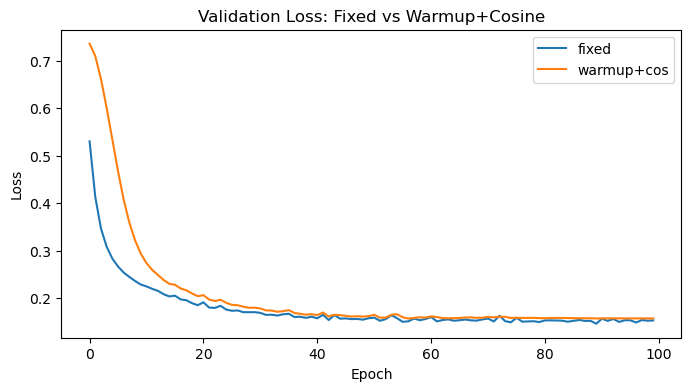

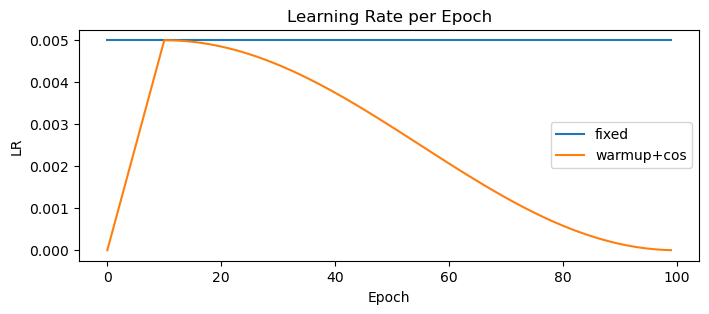

In [20]:
# Validation loss curves
plt.figure(figsize=(8,4))
plt.plot(va_f,  label="fixed")
plt.plot(va_wc, label="warmup+cos")
plt.title("Validation Loss: Fixed vs Warmup+Cosine")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Learning-rate profiles
plt.figure(figsize=(8,3))
plt.plot(lrs_f,  label="fixed")
plt.plot(lrs_used, label="warmup+cos")
plt.title("Learning Rate per Epoch")
plt.xlabel("Epoch"); plt.ylabel("LR"); plt.legend(); plt.show()


- **Warmup + Cosine** starts smoother (lower early loss volatility).

- It converges slightly better overall (Final Val Acc = 0.928 > 0.922).

- The l**earning-rate trajectory** follows the intended ramp-up → gradual cooldown pattern, avoiding the abrupt transitions typical of step schedules.

| Schedule            | Warmup Epochs | LR Profile                     | Final Val Acc | Behavior                                           |
| ------------------- | ------------- | ------------------------------ | ------------- | -------------------------------------------------- |
| **Fixed LR (5e-3)** | —             | Constant                       | 0.922         | Stable baseline; quick initial descent             |
| **Warmup + Cosine** | 10            | Linear 0→5e-3 then cosine to 0 | **0.928**     | Smoother early phase; best overall validation loss |

